# Explore the time-series of metrics in the pre-test period

IMPORTANT: This notebook uses an R kernel.

#### How to setup Jupyter Notebook for R

These instructions assume that you already have a working Python environment for your local repository of this project, and Jupyter Notebook already installed in that environment that you can execute from your Terminal.

1. Install R 

   If not already installed, see https://cloud.r-project.org/index.html
   

2. Install R kernel for Jupyter Notebook

    In your Terminal (note: not in RStudio, not in the R GUI):
    
    - launch R by entering `R` on the command line.

    - You should now be using R from your Terminal. Thus, run:
    ```
    install.packages('IRkernel')
    IRkernel::installspec()
    ```

    Done! You can now quit R by entering `q()`.

If you now launch Jupyter Notebook, you'll have the option to choose `R` as kernel.


### Setting things up

In [1]:
# Install packages, if they aren't already available.
# This can take a minute or two.
packages <- c("bigrquery", "tidyverse", "plotly", "gridExtra", "tsibble", "feasts", "DT", "TTR")
install.packages(setdiff(packages, rownames(installed.packages())), quiet = TRUE) 

In [2]:
for(pckg in packages){
    suppressPackageStartupMessages(library(pckg, character.only = TRUE))
}

In [4]:
#Authenticate
bq_auth(path = "/Users/alessiatosi/Secrets/govuk-bigquery-analytics-service-credentials.json")  #/path/to/your/service-account.json

In [5]:
# Make plots wider 
options(repr.plot.width=15, repr.plot.height=8)

In [6]:
# create custom plotting theme
theme_custom <- theme(plot.title = element_text(face = "bold", hjust = 0.5, size=18),
                      plot.subtitle = element_text(size=14),
                      axis.text.y = element_text(colour = 'black', size = 12), 
                      axis.title.y = element_text(size = 16, hjust = 0.5, vjust = 0.2),
                      axis.text.x = element_text(colour = 'black', size = 12), 
                      axis.title.x = element_text(size = 16, hjust = 0.5, vjust = 0.2),
                      panel.background = element_blank(),
                      axis.line = element_line(colour = "black"),
                      legend.position = "bottom",
                      legend.direction = "horizontal")

### Get the data

In [7]:
#billing <- "govuk-xgov" # replace this with your project ID 
project = "govuk-bigquery-analytics"
sql <- "SELECT * FROM `govuk-bigquery-analytics.datascience.related_links_20211011_20211119_pre_test_data`"

tb <- bq_table_download(bq_project_query(project, sql))

In [8]:
tb

date,visitors,visitors_that_clicked_rl,visitors_2_or_more_rl,visitors_that_clicked_navigation,visitors_that_clicked_rl_and_no_nav,visitors_that_used_search,pc_visitors_used_rl,pc_visitors_2_or_more_rl,pc_visitors_returning_to_rl,pc_visitors_that_clicked_navigation,pc_visitors_that_used_search
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20211111,1968540,33951,7228,31133,30515,1201,0.01725,0.00367,0.21290,0.01582,0.00061
20211019,2077660,39611,8401,38534,35400,1262,0.01907,0.00404,0.21209,0.01855,0.00061
20211021,2041264,34817,7269,34254,31235,1235,0.01706,0.00356,0.20878,0.01678,0.00061
20211015,1822116,32551,6587,30692,29273,1117,0.01786,0.00362,0.20236,0.01684,0.00061
20211028,1965192,36509,7505,32071,32941,1137,0.01858,0.00382,0.20557,0.01632,0.00058
20211020,2166044,37331,7902,36806,33433,1259,0.01723,0.00365,0.21167,0.01699,0.00058
20211017,1411718,22195,4350,18273,20149,824,0.01572,0.00308,0.19599,0.01294,0.00058
20211119,1678176,26707,5761,27498,23954,973,0.01591,0.00343,0.21571,0.01639,0.00058
20211105,1622801,27880,5887,25386,25106,939,0.01718,0.00363,0.21115,0.01564,0.00058


### Data pre-processing

In [9]:
# cast date as a date type variable
tb$date <- as.Date(strptime(tb$date, "%Y%m%d"))

In [10]:
tb <- tb %>% 
    arrange(date)

### Plotting

In [11]:
plot_timeseries <- function(data, ts_var="", title="", x_title=""){
    #'@param data (data.frame) : dataset  
    #'@param ts_var (character string) : name of the variable containing the time-series data
    #'@param title (character string) : plot title
    #'@param x_title (character string) : x-axis title
    #'@return time-series plot
    
    if(!"date" %in% colnames(data)) stop(paste0("column `date` is missing from dataset"))
    
    sym_ts_var <- dplyr::sym(ts_var)
    
    data %>% 
    ggplot2::ggplot(., aes(date, !!sym_ts_var)) +
    geom_point(size=2) +
    geom_line(size=1) +
    #geom_smooth(method="lm", colour="blue") +
    geom_smooth(method = "loess", formula=y~x, colour="red", se=TRUE) +
    geom_vline(aes(xintercept = as.Date("20211111", "%Y%m%d")), col="blue", linetype=2) +
    geom_vline(aes(xintercept = as.Date("20211025", "%Y%m%d")), col="blue", linetype=2) +
    labs(
        title = title,
        subtitle = "Pre-intervention time series") +
    ylab(x_title) +
    theme_custom
    }

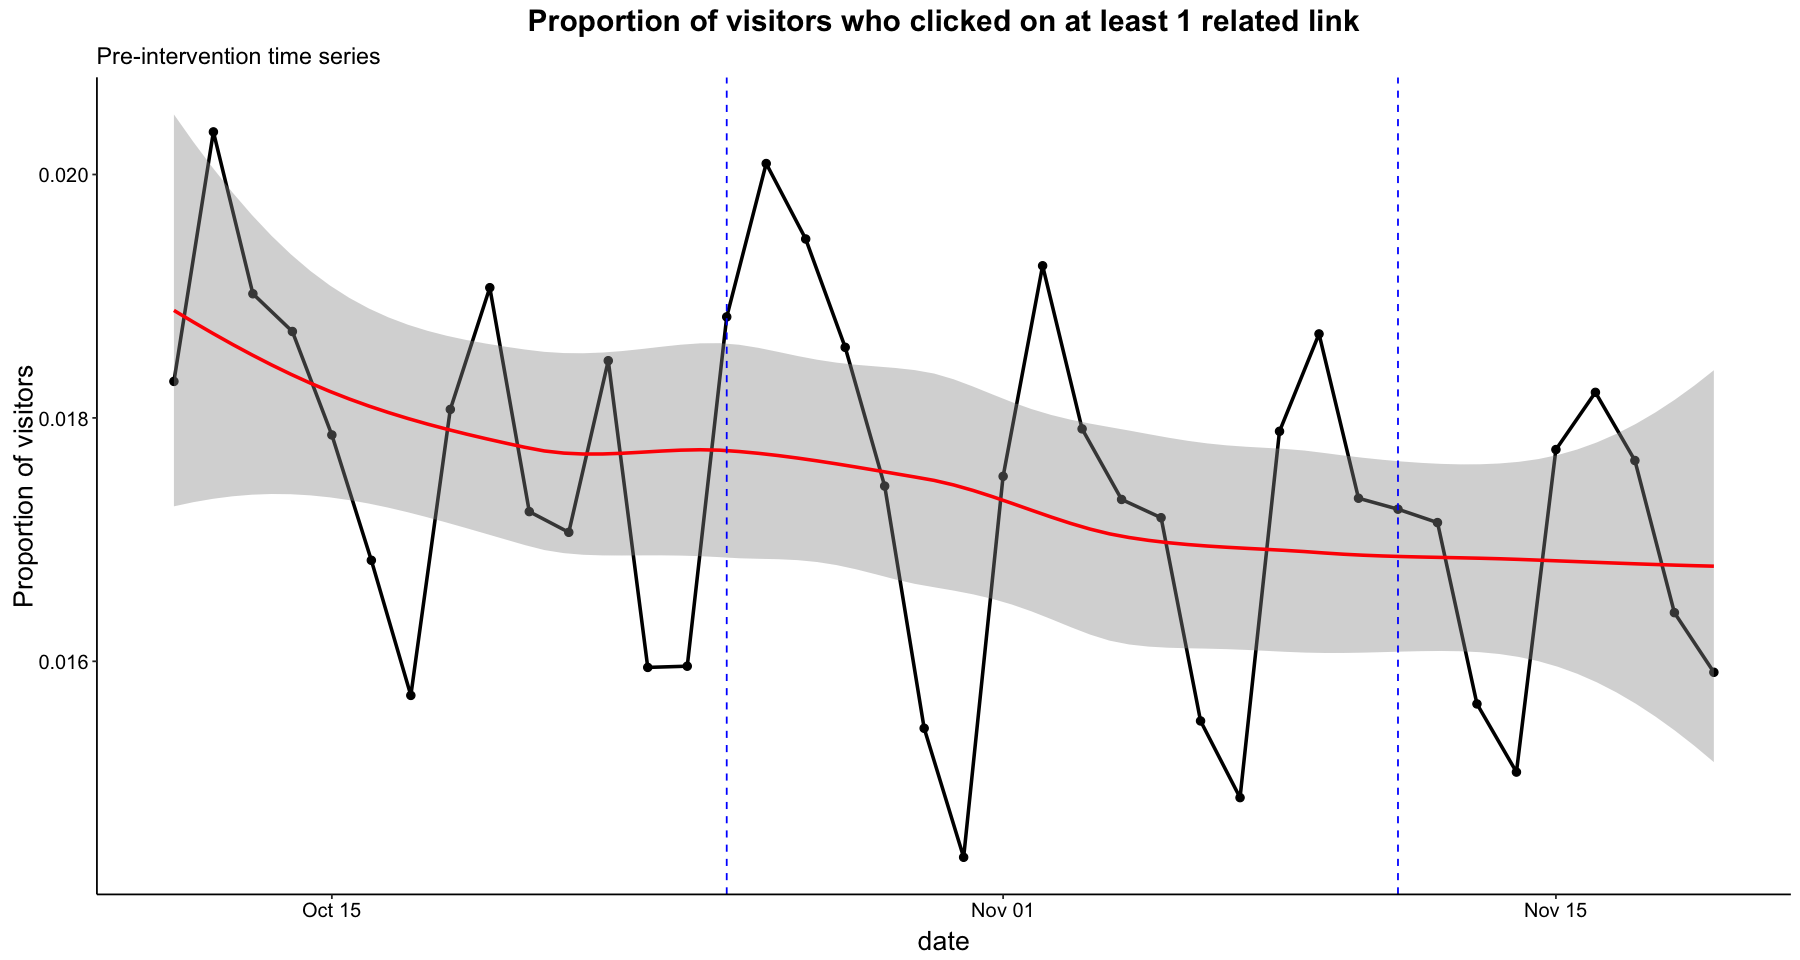

In [12]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_used_rl",
               title="Proportion of visitors who clicked on at least 1 related link",
               x_title="Proportion of visitors")

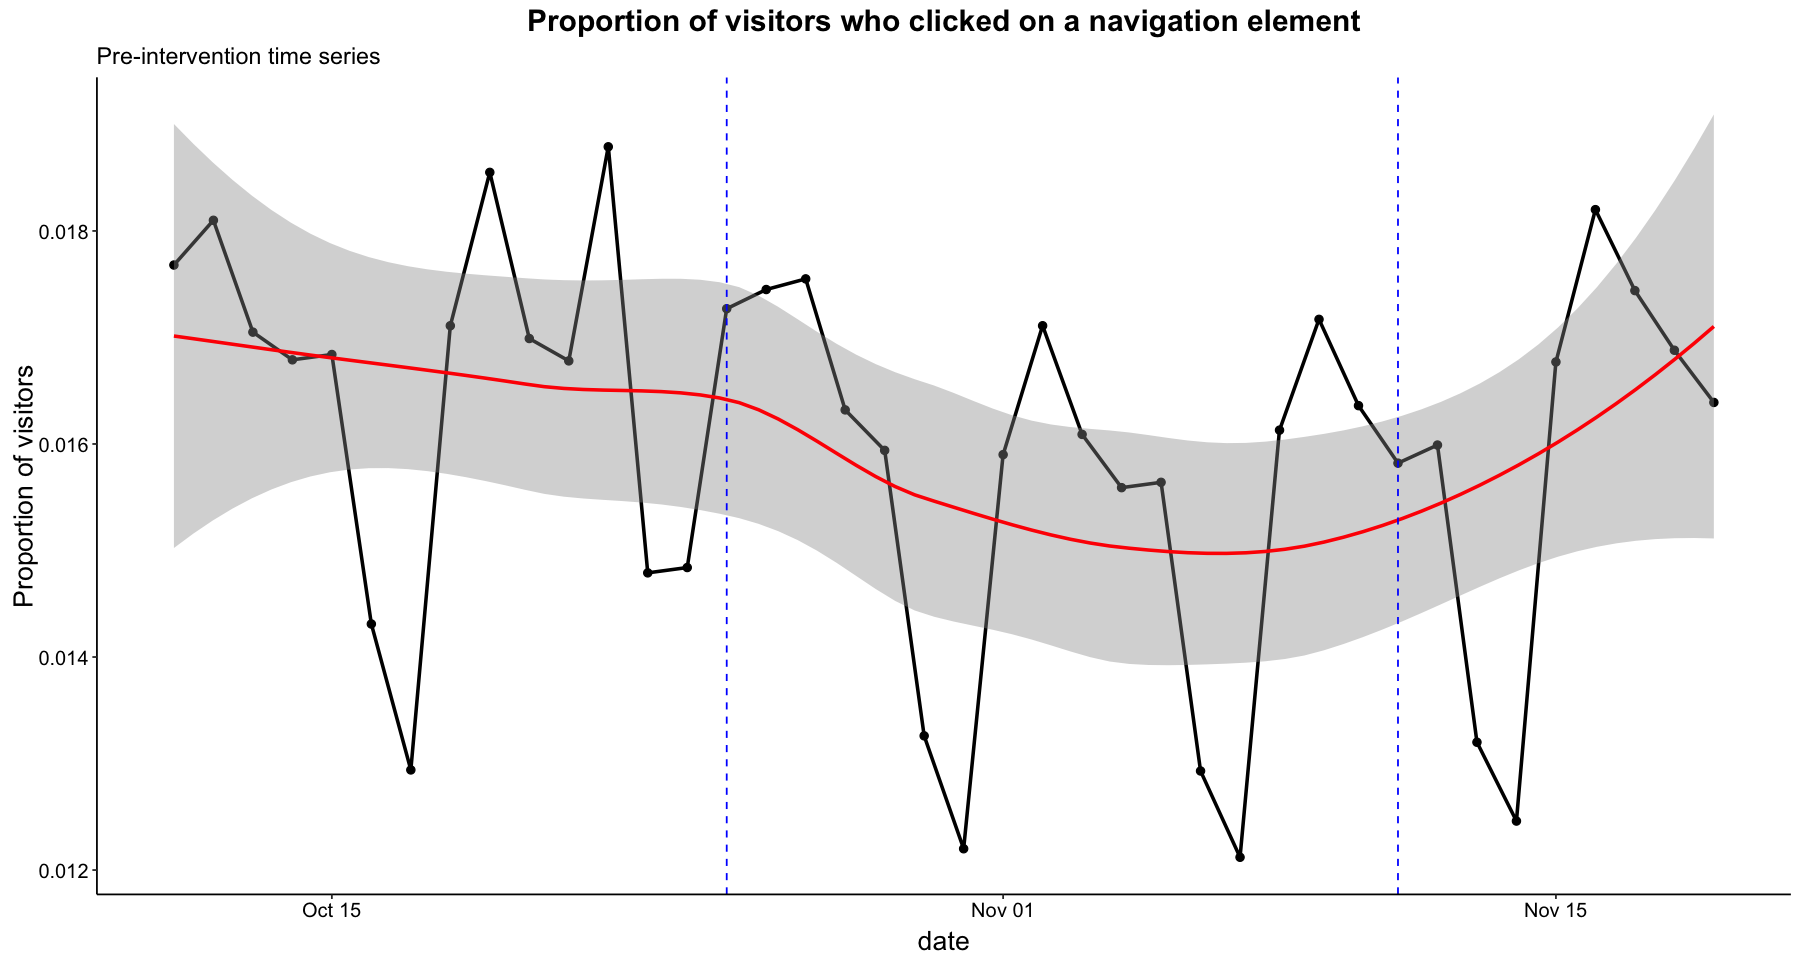

In [13]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_that_clicked_navigation",
               title="Proportion of visitors who clicked on a navigation element",
               x_title="Proportion of visitors")

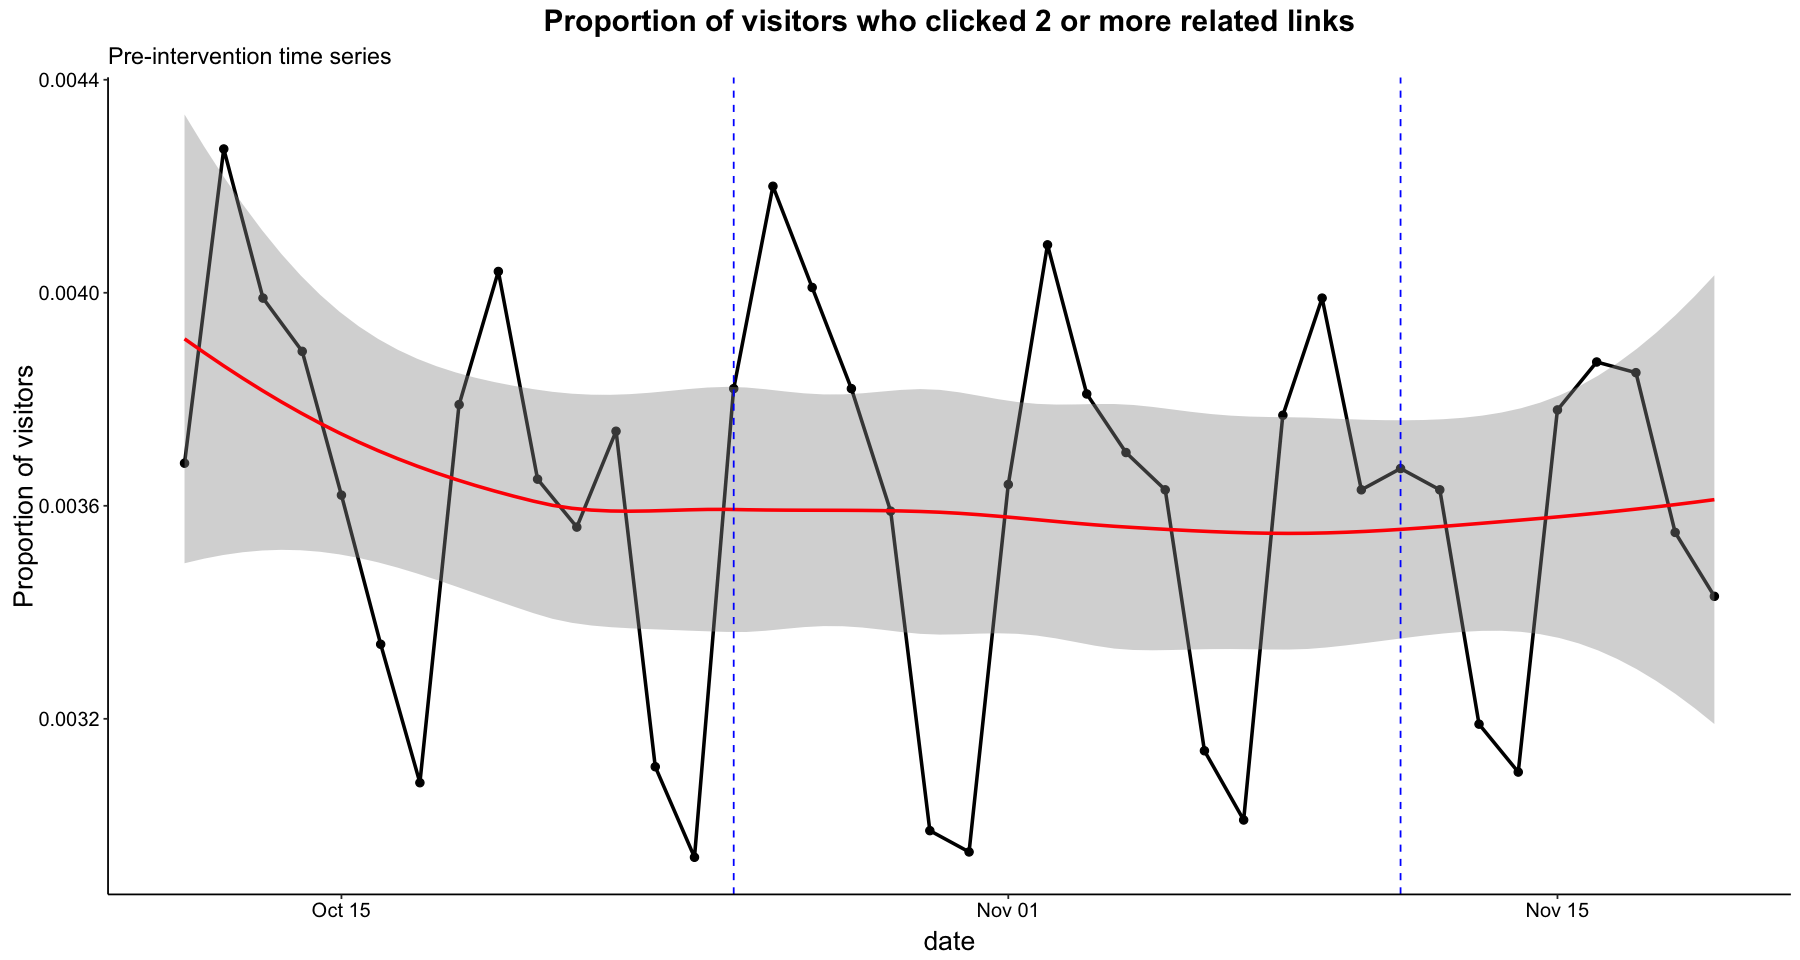

In [14]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_2_or_more_rl",
               title="Proportion of visitors who clicked 2 or more related links",
               x_title="Proportion of visitors")

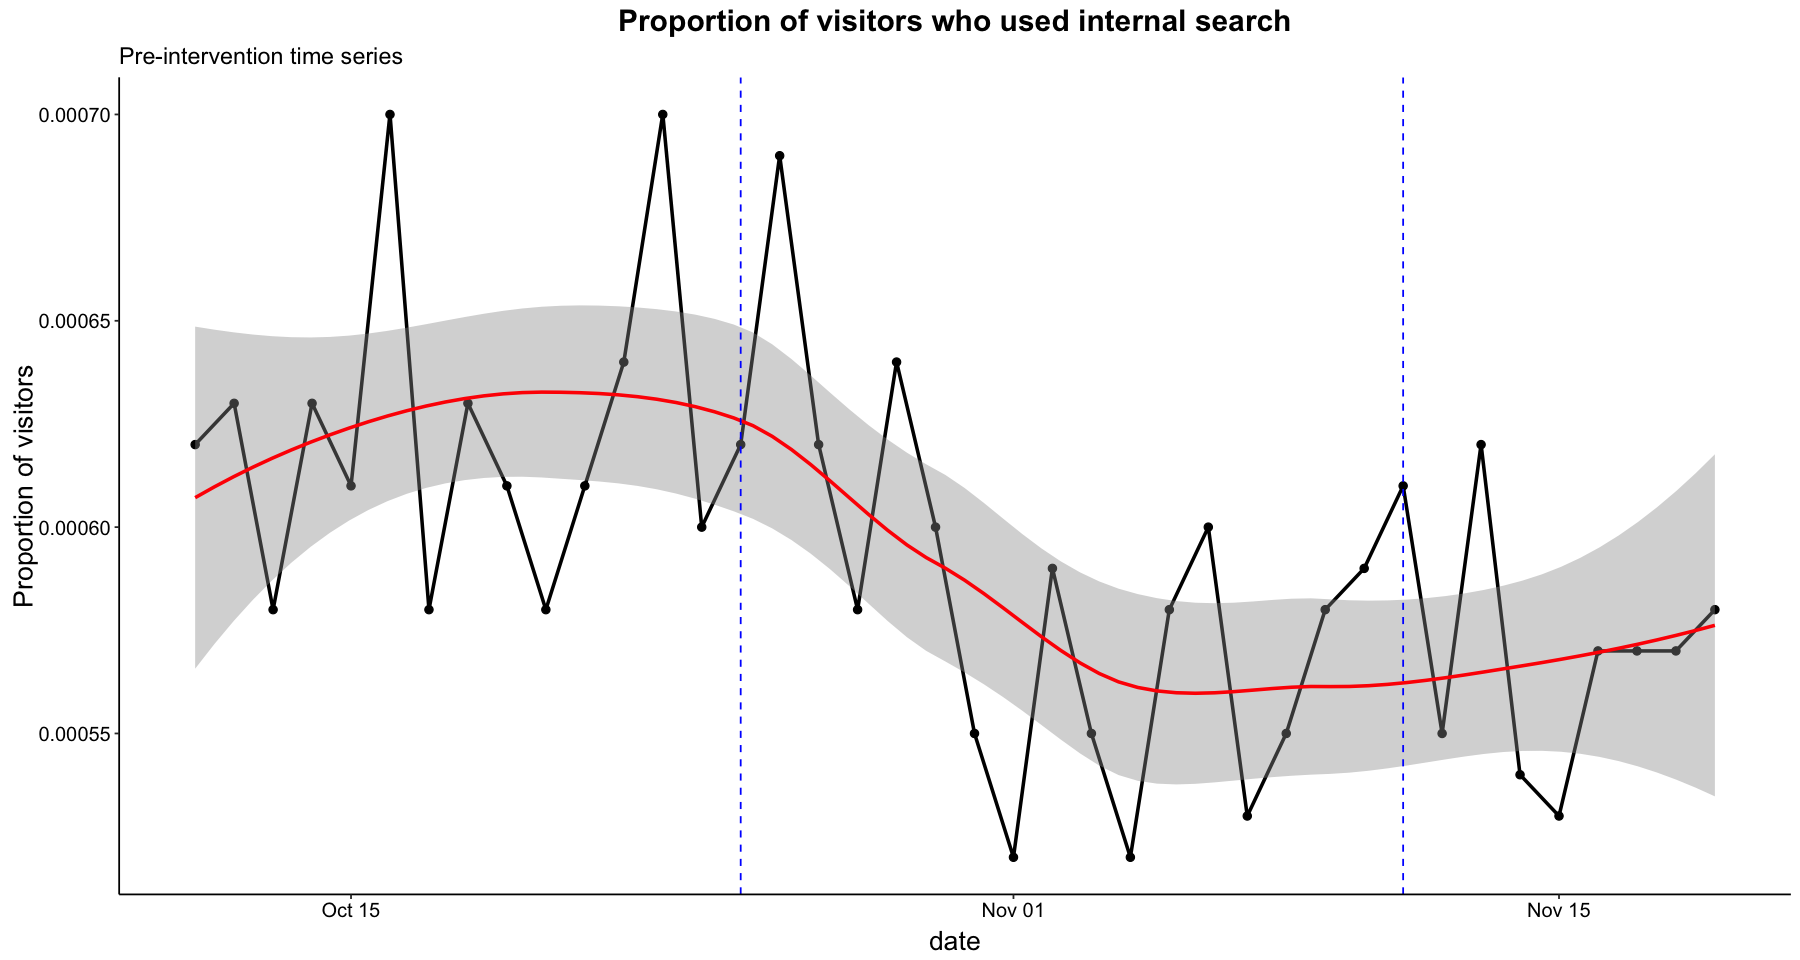

In [15]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_that_used_search",
               title="Proportion of visitors who used internal search",
               x_title="Proportion of visitors")

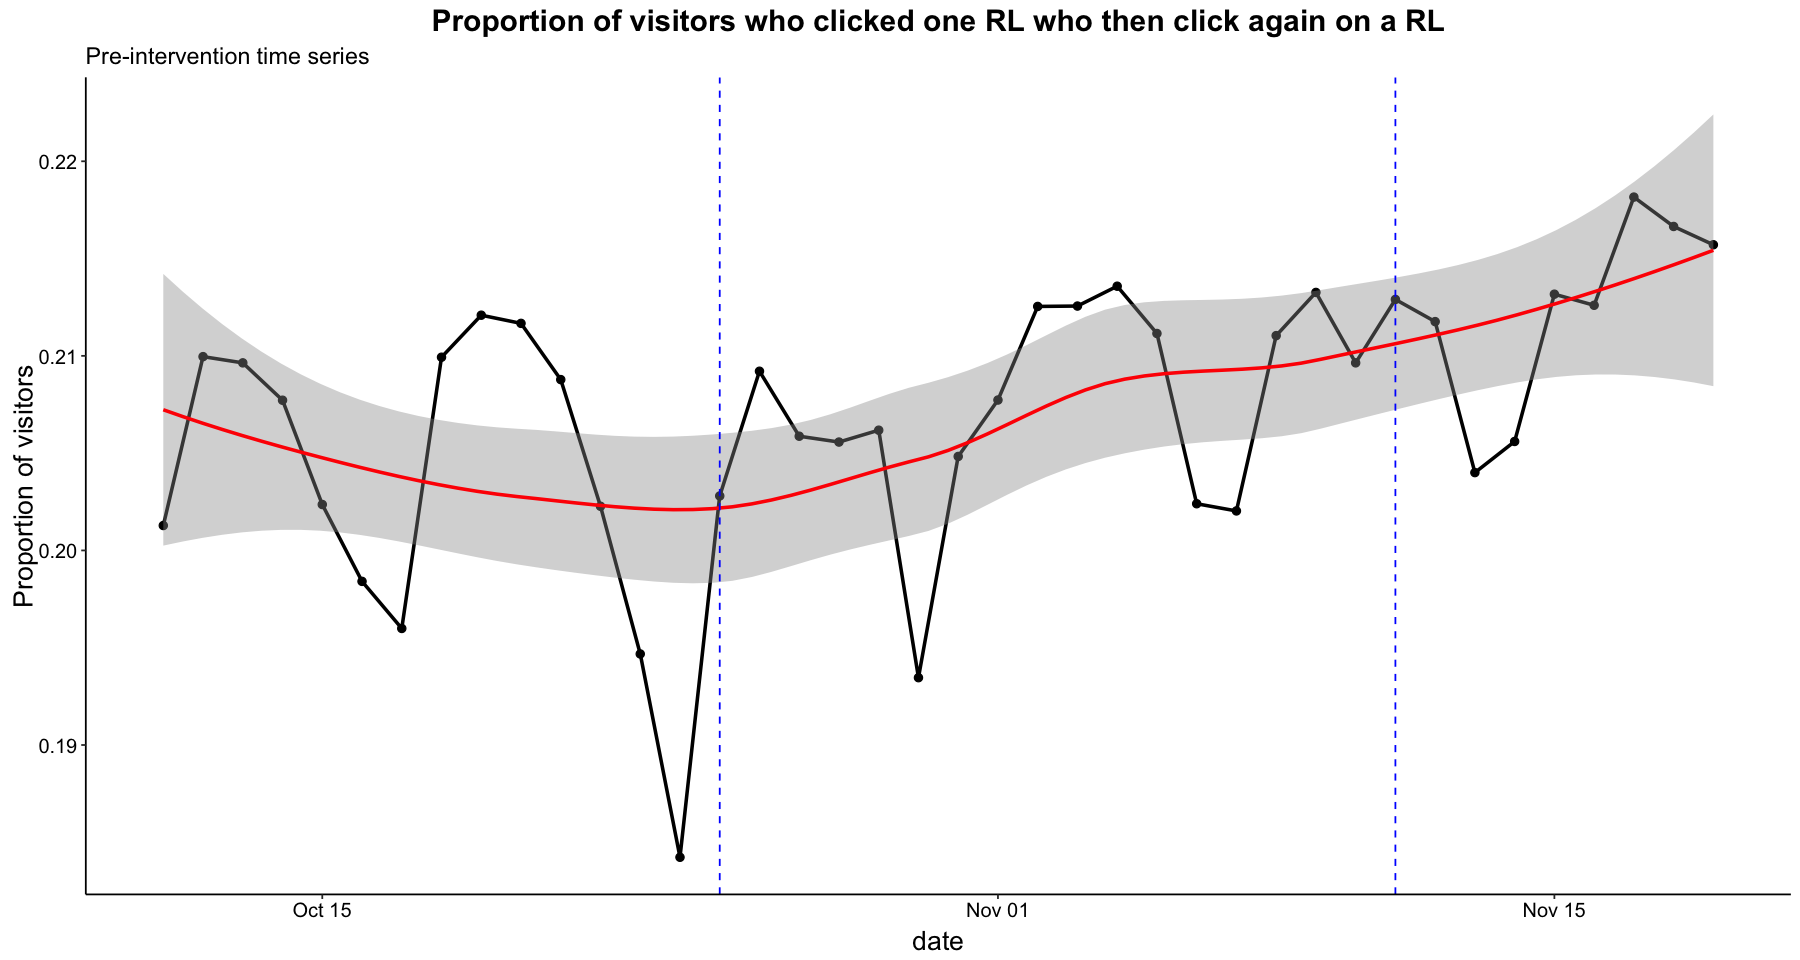

In [16]:
plot_timeseries(data=tb,
               ts_var="pc_visitors_returning_to_rl",
               title="Proportion of visitors who clicked one RL who then click again on a RL",
               x_title="Proportion of visitors")

### Trends, seasonality and stationarity

- **Trend**: whether and when there is an overall increasing or decreasing pattern in our observations over time
- **Seasonality**: whether and when there are repeating patterns in the series at fixed and known periods (e.g., weekly)
- **Stationarity**: when a time-series has constant mean, variance and covariance over time
Put another way, a time-series is **stationary** when it has no trend nor seasonality, and has constant variance over time. Typically, this will mean when you plot values over time, it will be roughly horizontal (though some cyclic behaviour is possible) and have constant variance.

- **Remainder/random noise**: leftover of original time-series after trend and seasonality are removed
- **Autocorrelation**: the strength of the relationship between a variable and its observations at prior time-periods
The **autocorrelation function** is a plot of a **stationary** time-series with its lags (meaning its observations at prior time-periods). It can be used to obtain the order of a **moving-average model**, *q*. It will be the first lag at which the **autocorrelation** value passes the upper 95% **confidence interval**, as indicated by the blue dotted line in the corresponding **ACF** plot.

- **Partial autocorrelation**: the strength of the relationship between an observation in a time-series with its observations at prior time-peridos, with the relationships of intervening observations removed
**Partial autocorrelation** is different to **autocorrelation** because the latter is comprised of both *direct* and *indirect* correlations, whereas the former removes these *indirect* correlations. It can be used to obtain the order of an auto-regressive model, *p*.^[Indirect correlations are a linear function of the correlation of the observation, with observations at intervening time periods.]

We explore **trend** to help identify whether the shares in page view traffic by device cateogry has evolved over time, and whether this change in the cookie-policy has further affected this trend in any peculiar way. Whereas for the **ACF** and **PACF** concepts, we explore these to inform our choice of the statistical method to model our time-series data with.


In [17]:
# convert to time-series object
tb <- tb %>%
    tsibble::as_tsibble(index = date)

In [18]:
plot_SLT <- function(data, ts_var="", title_ts_var=""){
    #'@param data (data.frame) : dataset  
    #'@param ts_var (character string) : name of the variable containing the time-series data
    #'@param title_ts_var (character string) : Plain English description of time-series variable
    #'@return time-series plot
    
    if(!"date" %in% colnames(data)) stop(paste0("column `date` is missing from dataset"))
    
    sym_ts_var <- dplyr::sym(ts_var)
    
    decomp <- data %>% model(STL(!!sym_ts_var)) %>% components()
    
    p1 <- data %>%
        feasts::gg_tsdisplay(y = !!sym_ts_var, plot_type = "partial") + 
        labs(title = paste(title_ts_var, "- Time, ACF and PACF plots"))
    
    p2 <- decomp %>% autoplot()
    
    list(p1, p2)
    }

#### Proportion of visitors who click RL at least once

[[1]]

[[2]]


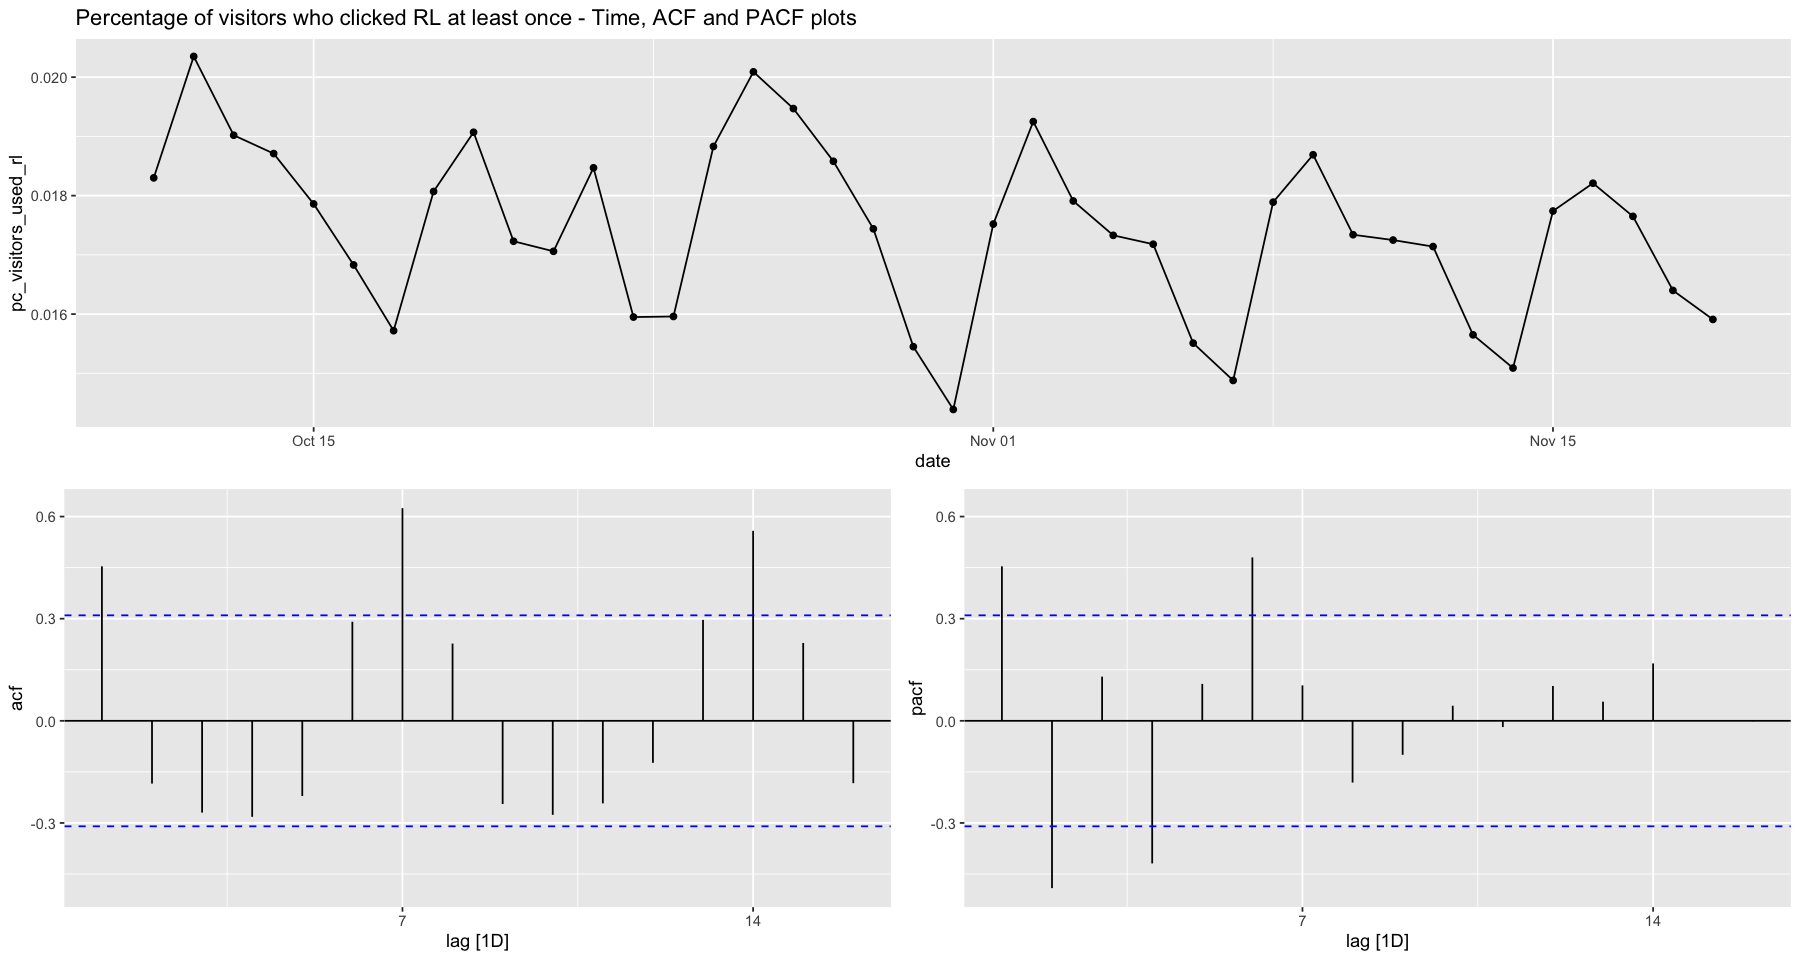

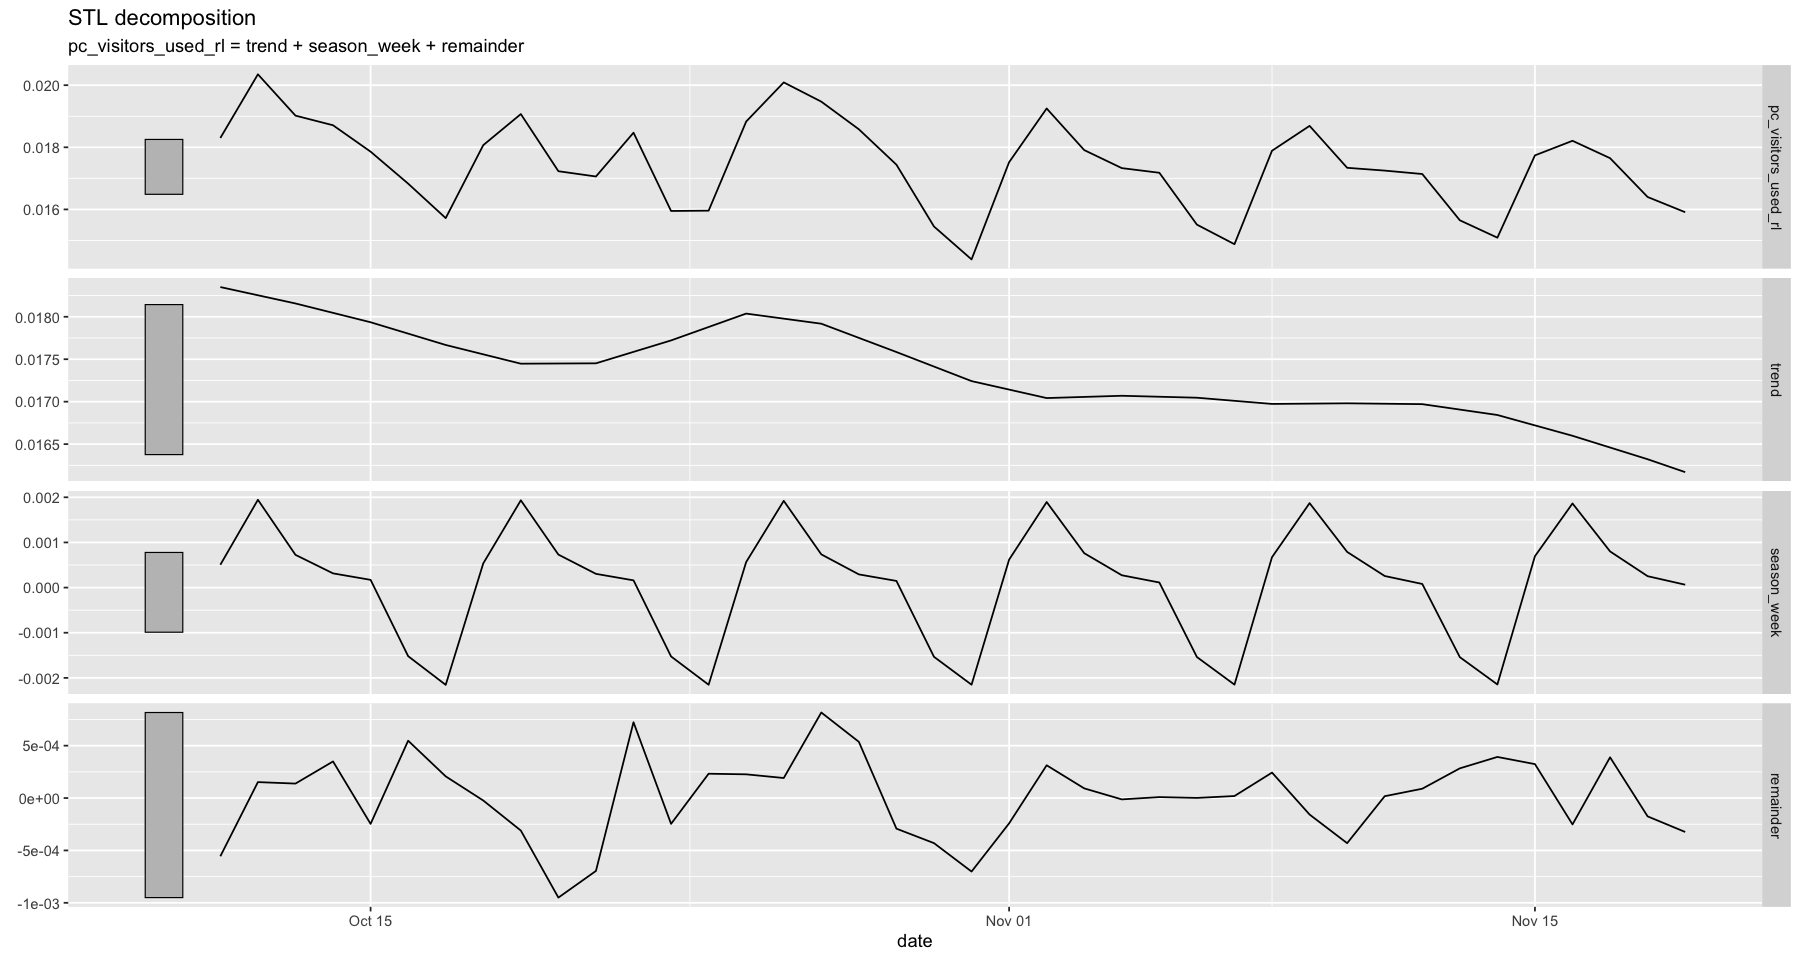

In [19]:
plot_SLT(tb, "pc_visitors_used_rl", "Percentage of visitors who clicked RL at least once")

#### Proportion of repeated-clicker visitors

[[1]]

[[2]]


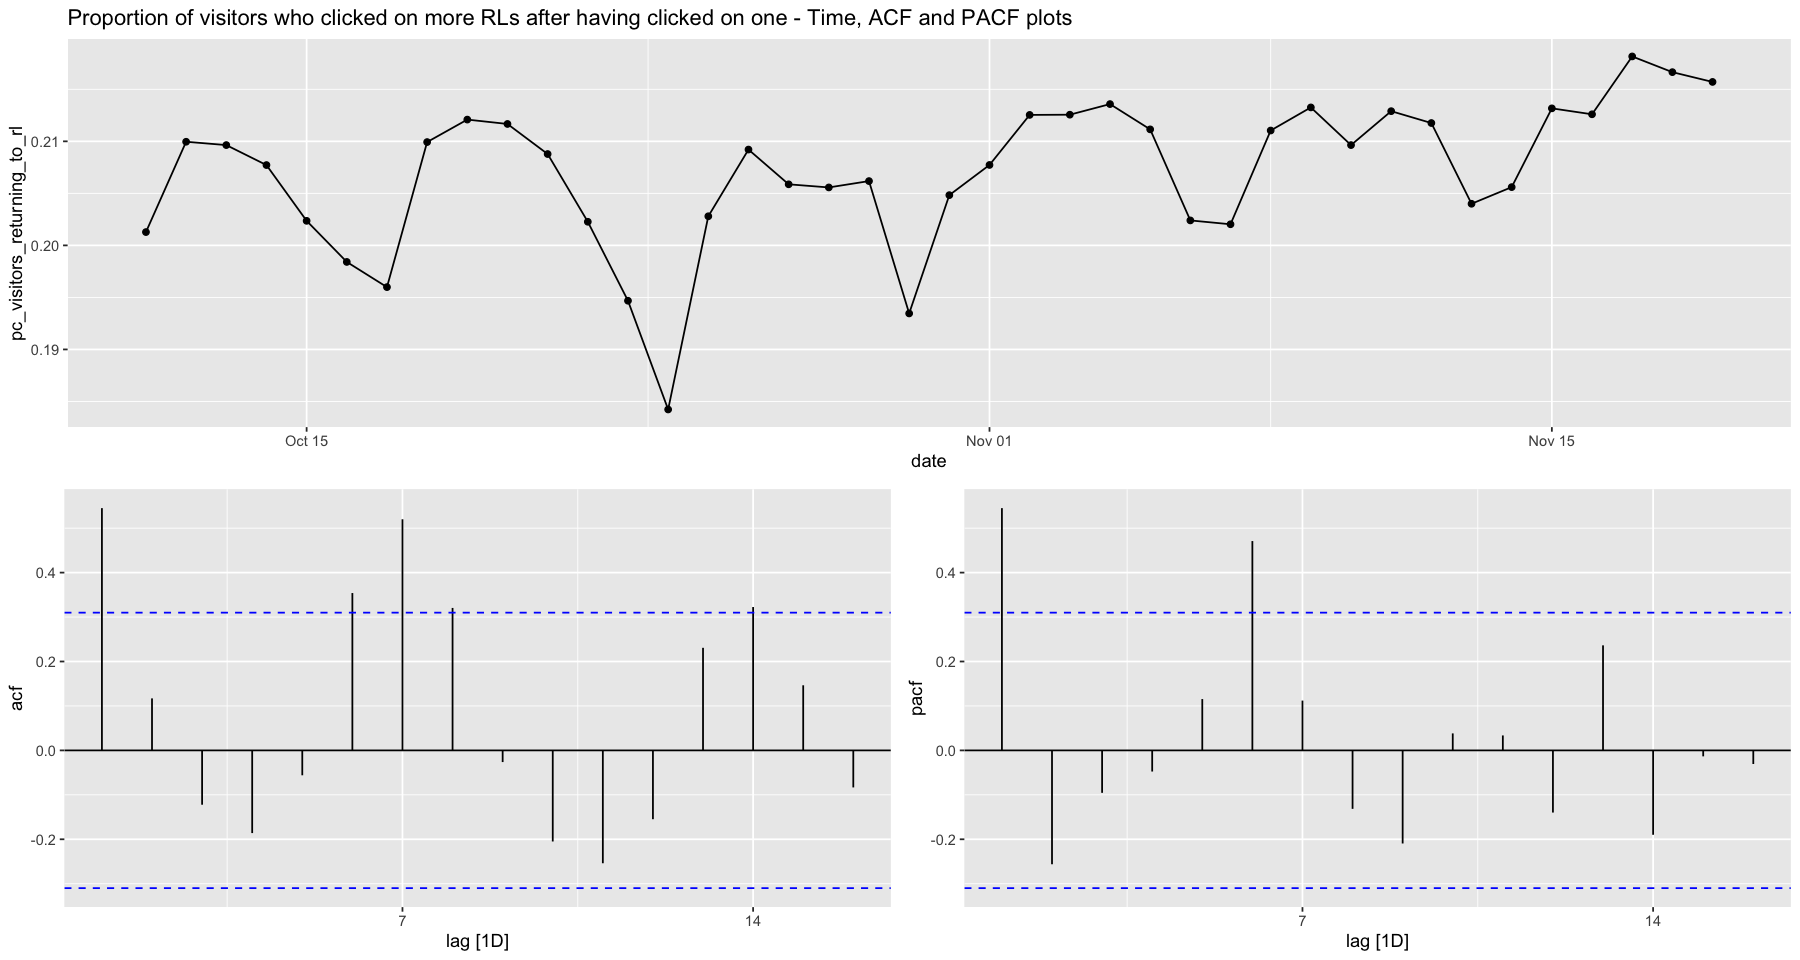

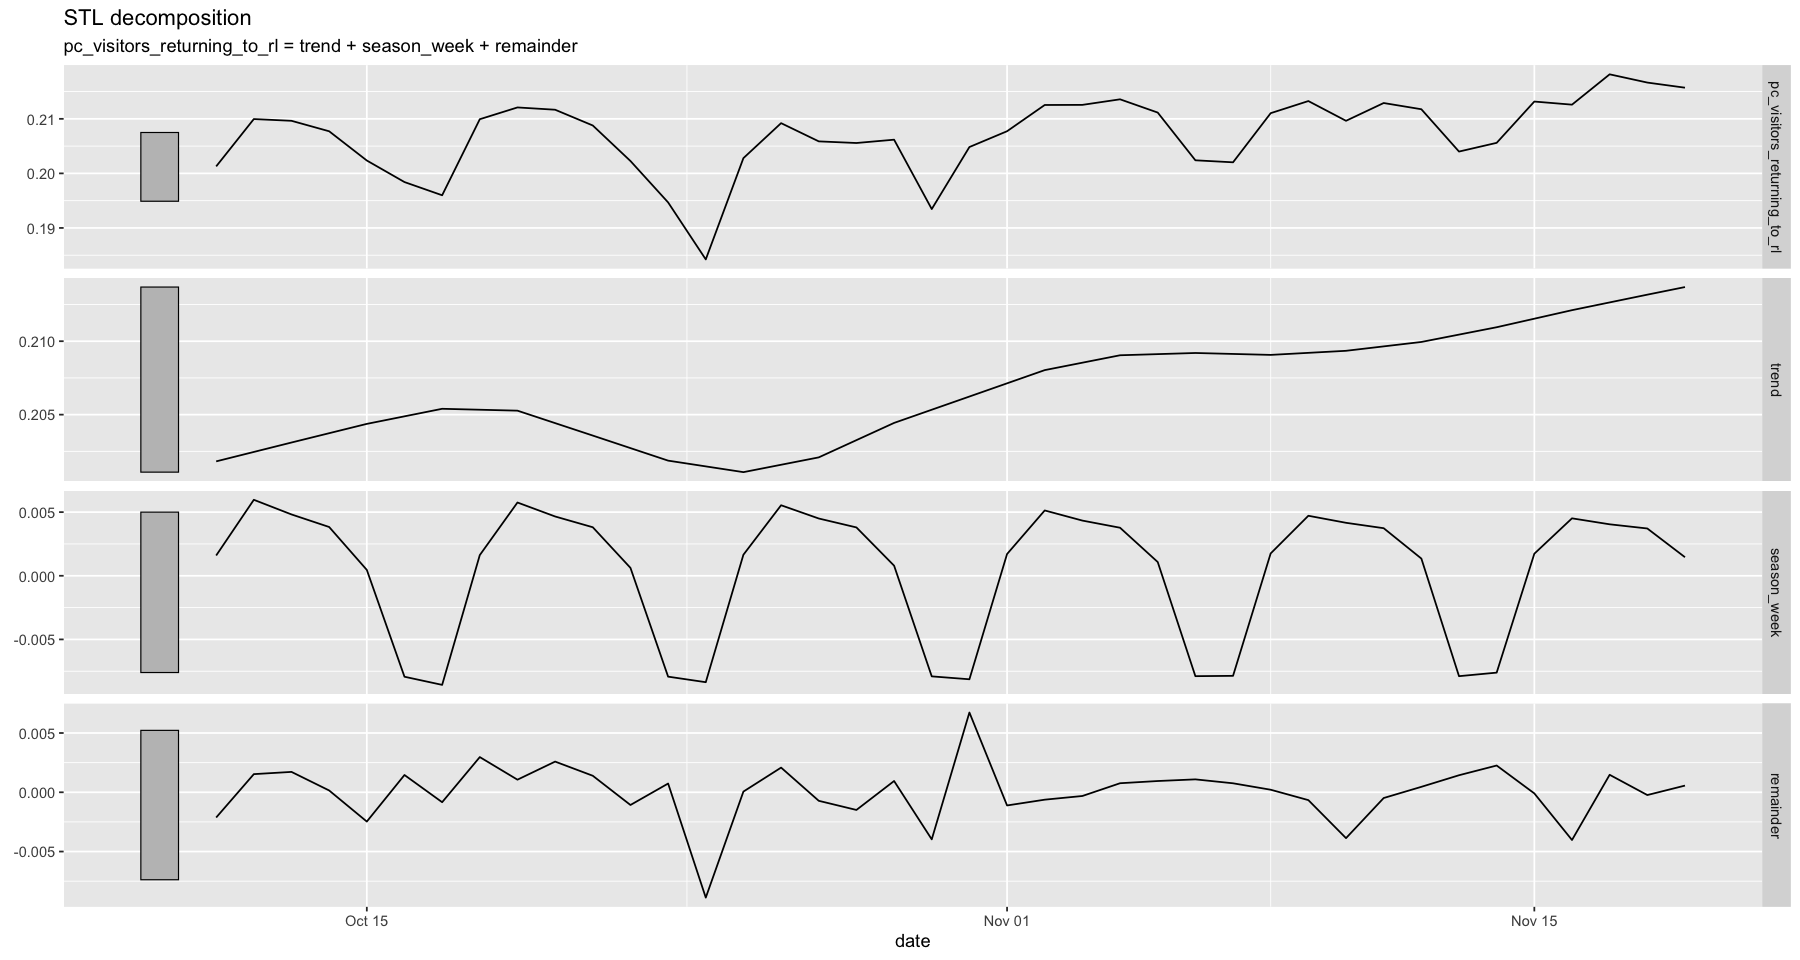

In [20]:
plot_SLT(tb, "pc_visitors_returning_to_rl", 
         "Proportion of visitors who clicked on more RLs after having clicked on one")

#### Proportion of visitors who clicked on a navigation element while on a RL page

[[1]]

[[2]]


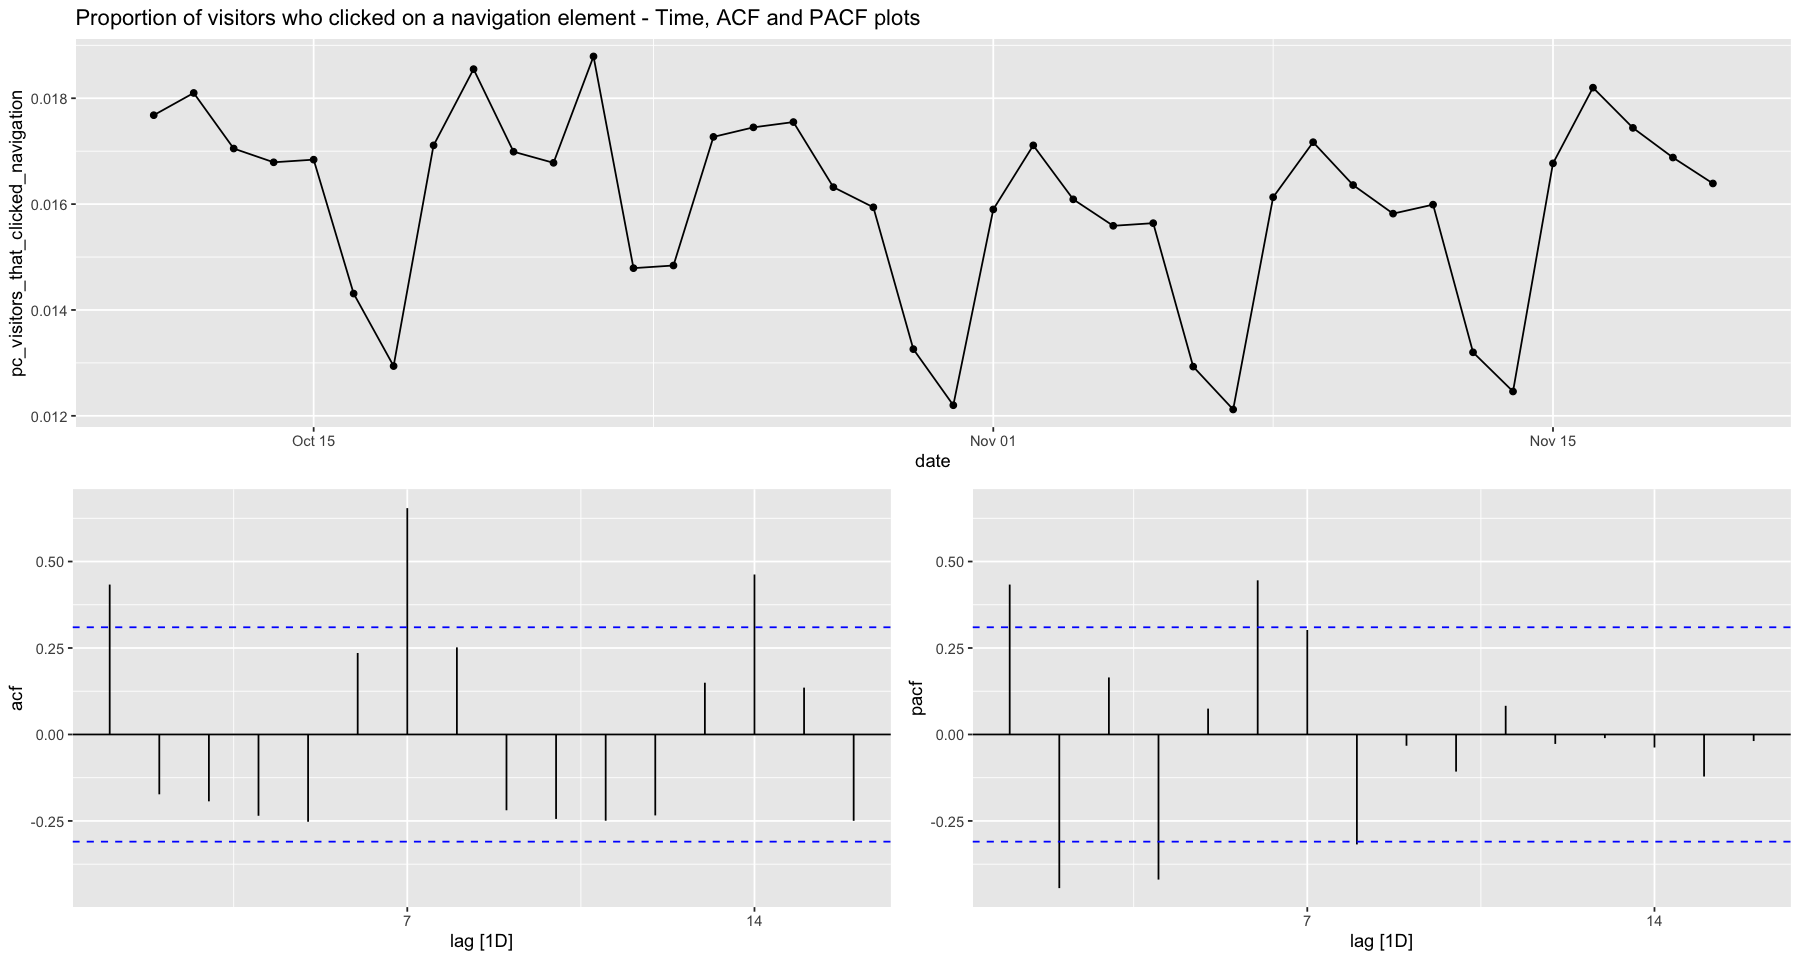

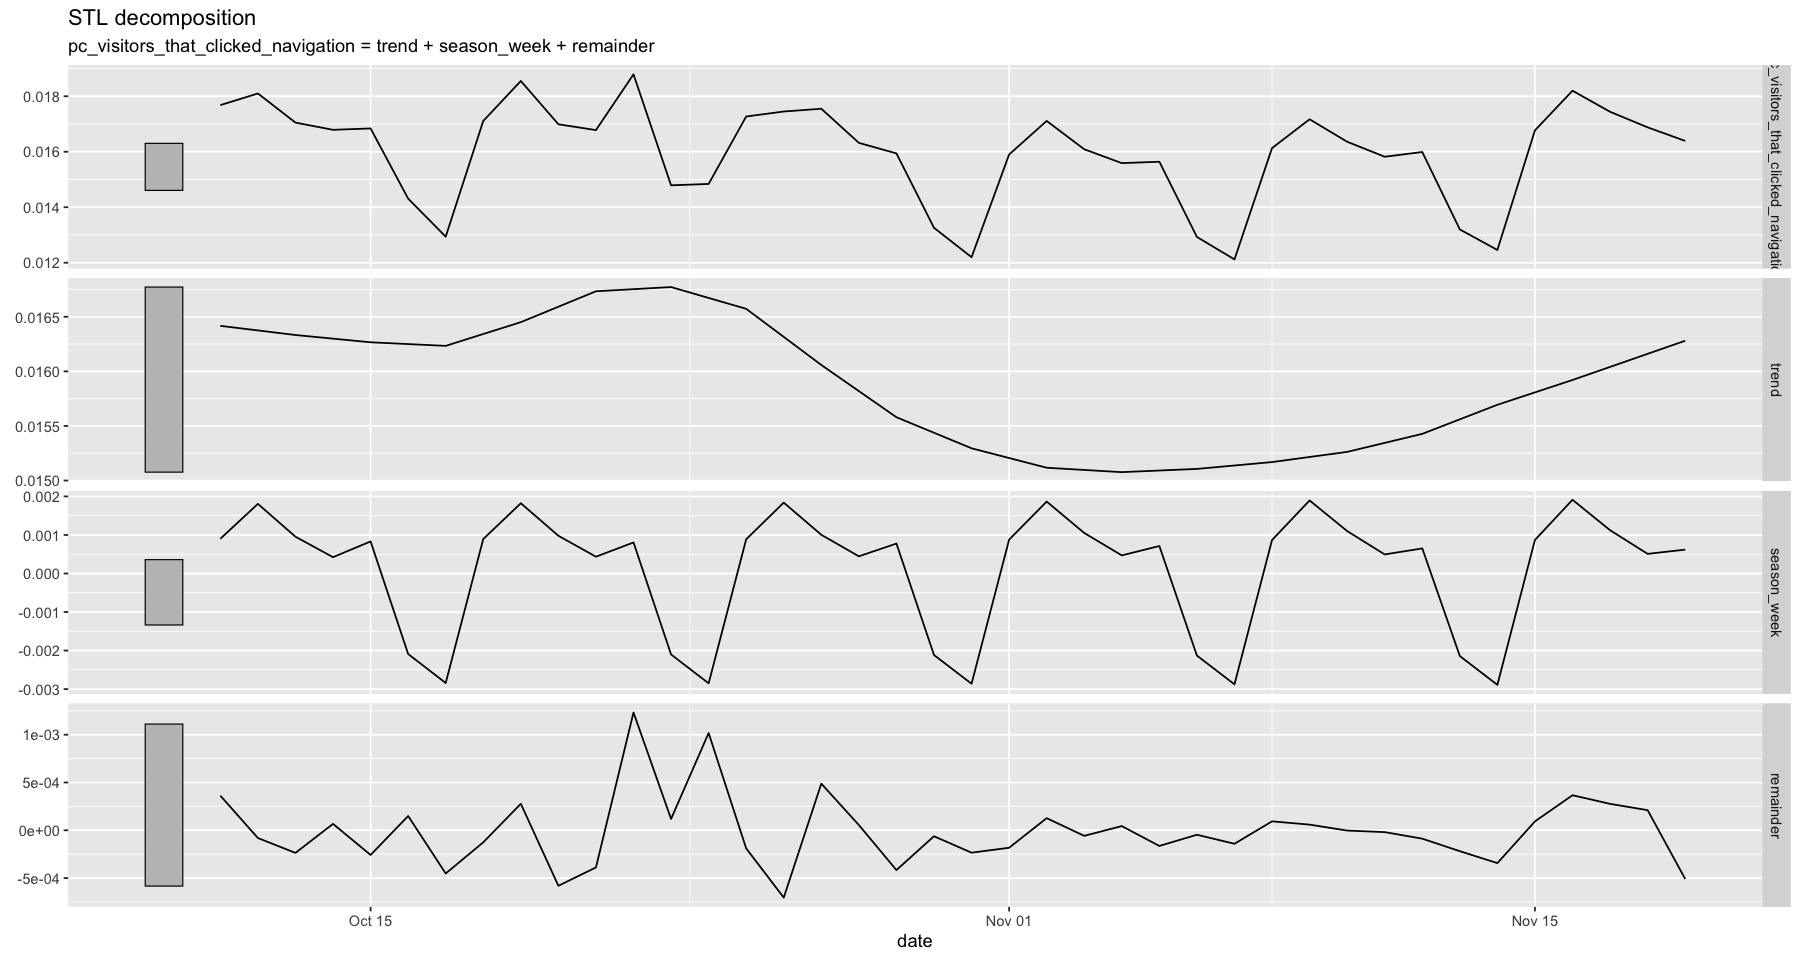

In [21]:
plot_SLT(tb, "pc_visitors_that_clicked_navigation", 
         "Proportion of visitors who clicked on a navigation element")